In [1]:
import numpy as np
import sys
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
import importlib

In [2]:
from ecco_download import *

ecco_podaac_download(ShortName="ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                    StartDate="2000-01-09",EndDate="2000-01-14",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /home/m267zhou/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4
{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '2000-01-09,2000-01-14'}

Total number of matching granules: 1

GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading
DL Progress: 100%|########################| 1/1 [00:00<00:00, 11683.30it/s]

total downloaded: 0.0 Mb
avg download speed: 0.0 Mb/s


In [3]:
# download file (granule) containing 2000 velocities,
# to default path ~/Downloads/ECCO_V4r4_PODAAC/
vel_monthly_shortname = "ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4"
ecco_podaac_download(ShortName=vel_monthly_shortname,\
                    StartDate="2000-01-02",EndDate="2000-12-31",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /home/m267zhou/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4
{'ShortName': 'ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2000-01-02,2000-12-31'}

Total number of matching granules: 12

OCEAN_VELOCITY_mon_mean_2000-02_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-01_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-03_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-04_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-05_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-07_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-08_ECCO_V4r4_native_llc0090.nc already exist

In [4]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [5]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

In [6]:
## Load the model grid
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])

In [7]:
## Load monthly SSH from 2000
ecco_vars = xr.open_mfdataset(join(ECCO_dir,'*VEL*MONTHLY*','*_2000-*.nc'))

ecco_ds = []

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_ds = xr.merge((ecco_grid , ecco_vars)).load()


In [8]:
#rotation
xfld = ecco_ds.UVEL.isel(time=0, k=0)
yfld = ecco_ds.VVEL.isel(time=0, k=0)

# Compute the zonal and meridional vector components of oceTAUX and oceTAUY
UVEL, VVEL  = ecco.vector_calc.UEVNfromUXVY(xfld, yfld, ecco_ds)

In [9]:
#create arrays for velocity components
zonal_vel = np.zeros((1300,1800))
meri_vel = np.zeros((1300,1800))

In [10]:
#interpolation in an arbitrary grid with large resolution
new_grid_delta_lat = 0.05
new_grid_delta_lon = 0.05

new_grid_min_lat = 10
new_grid_max_lat = 75

new_grid_min_lon = -130
new_grid_max_lon = -40

# interpolate to lat-lon
new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
UVEL_latlon =\
        ecco.resample_to_latlon(ecco_ds.XC, \
                                ecco_ds.YC, \
                                UVEL,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 1200000)

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
VVEL_latlon =\
        ecco.resample_to_latlon(ecco_ds.XC, \
                                ecco_ds.YC, \
                                VVEL,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 1200000)
zonal_vel = UVEL_latlon
meri_vel = VVEL_latlon

In [11]:
# make the new data array structures for the UVEL
zonal_vel_DA = xr.DataArray(zonal_vel,  name = 'oceTAUE', 
                      dims = ['latitude','longitude'], 
                      coords = {'latitude': new_grid_lat_centers[:,0],
                                'longitude': new_grid_lon_centers[0,:]})

# make the new data array structures for the VVEL
meri_vel_DA = xr.DataArray(meri_vel,  name = 'oceTAUN', 
                      dims = ['latitude','longitude'], 
                      coords = {'latitude': new_grid_lat_centers[:,0],
                                'longitude': new_grid_lon_centers[0,:]})

In [12]:
speed = np.sqrt(zonal_vel_DA**2 + meri_vel_DA**2)

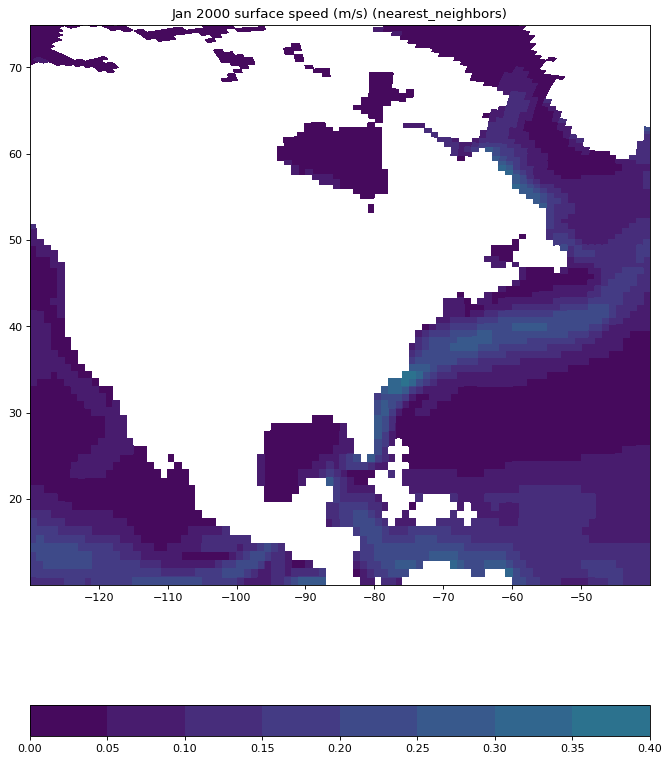

In [13]:
#plot speed profile
plt.figure(figsize=(10,13), dpi= 80);
plt.contourf(zonal_vel_DA.longitude, zonal_vel_DA.latitude, speed, vmin=0, vmax=1.0)
plt.title('Jan 2000 surface speed (m/s) (nearest_neighbors)');
plt.colorbar(orientation='horizontal');

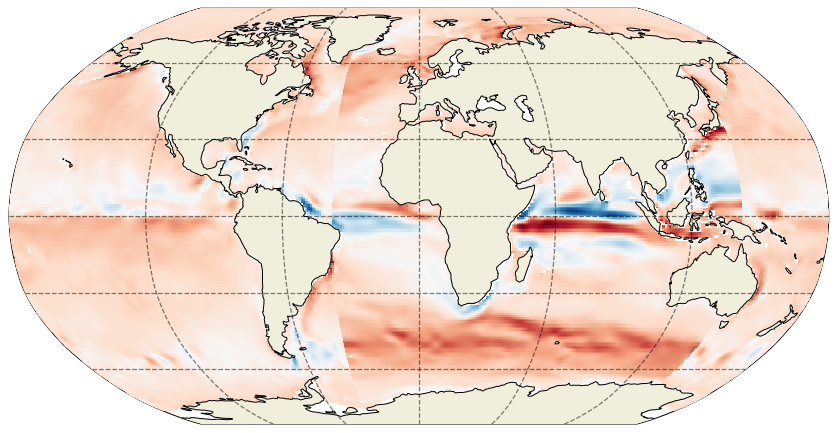

In [14]:
#global UVEL profile
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ecco_ds.UVEL.isel(time=0, k=0)
tmp_plt = tmp_plt.where(ecco_ds.hFacW.isel(k=0) !=0)

a=ecco.plot_proj_to_latlon_grid(ecco_ds.XC, \
                                ecco_ds.YG, \
                                tmp_plt, \
                                plot_type = 'pcolormesh', \
                                dx=0.5,\
                                dy=0.5, \
                                projection_type = 'robin',\
                                less_output = True);


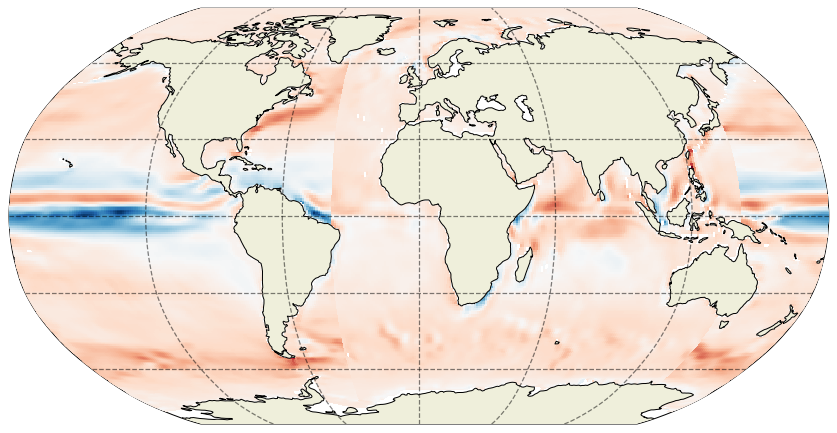

In [15]:
#global VVEL profile
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ecco_ds.VVEL.isel(time=0, k=0)
tmp_plt = tmp_plt.where(ecco_ds.hFacS.isel(k=0) !=0)

a=ecco.plot_proj_to_latlon_grid(ecco_ds.XG, \
                                ecco_ds.YC, \
                                tmp_plt, \
                                plot_type = 'pcolormesh', \
                                dx=0.5,\
                                dy=0.5, \
                                projection_type = 'robin',\
                                less_output = True);


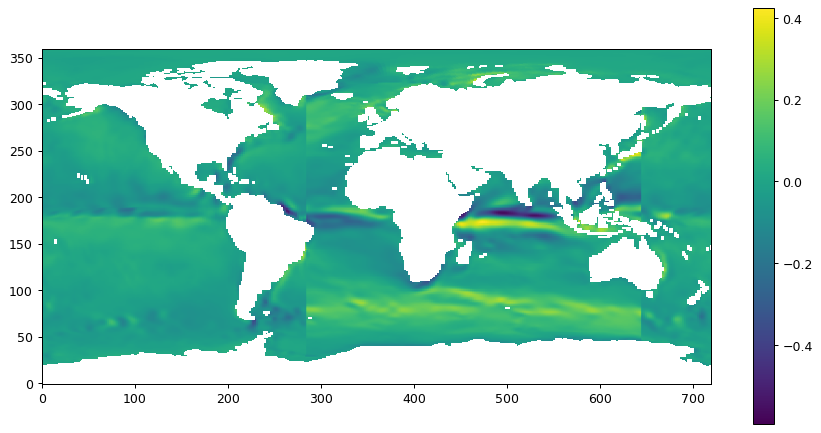

In [16]:
#interpolate globally
new_grid_delta_lat = 0.5
new_grid_delta_lon = 0.5

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field_nearest_1deg =\
        ecco.resample_to_latlon(ecco_ds.XC, \
                                ecco_ds.YG, \
                                ecco_ds.UVEL.isel(time=0, k=0),\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

# plot the whole field
plt.figure(figsize=(12,6), dpi= 90)
plt.imshow(field_nearest_1deg,origin='lower')
plt.colorbar()